# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
from functools import reduce

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import re


In [2]:
# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
## check the parameters
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '38627'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1577508624295'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'bf73f55ddf1b')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
## load the data
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
## to look at dataframe structure
df_spark = df.toPandas()
df_spark.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [8]:
df.count()

286500

In [9]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [10]:
df = df.filter(df.userId!="")
df.count()

278154

In [11]:
# How many users in the dataset?
df.select('userId').dropDuplicates().count()

225

In [12]:
df.groupby(['auth']).count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [13]:
df.groupby("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



#### Comments from EDA
While looking at the page variable to understand types of pages and churn pattern, it can be seen that this coulmn has "Cancel" and "Cancellation Confirmation" columns whose values are exactly same. 

For the purpose of churn analysis, we will take "Cancellation Confirmation" column into consideration.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [14]:
### create churn column
churned_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()

In [15]:
churned_users.show(5)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
+------+
only showing top 5 rows



In [16]:
### create a list of churned user ids
churn_list = [(row['userId']) for row in churned_users.collect()]

In [17]:
churn_list[0:4]

['125', '51', '54', '100014']

In [18]:
df_churned = df.withColumn("churn", df.userId.isin(churn_list))

In [19]:
## check if churn col is created
df_churned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)



In [20]:
## check if it has been created
df_churn = df_churned.toPandas()
df_churn.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### check how many users are churned

In [21]:
df_churned.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
| true|   52|
|false|  173|
+-----+-----+



In [22]:
df_churned.dropDuplicates(['userId']).groupby(['gender','churn']).count().sort('churn').show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|false|   84|
|     M|false|   89|
|     M| true|   32|
|     F| true|   20|
+------+-----+-----+



#### gender wise distribution of churn

In [23]:
df_gender=df_churned.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

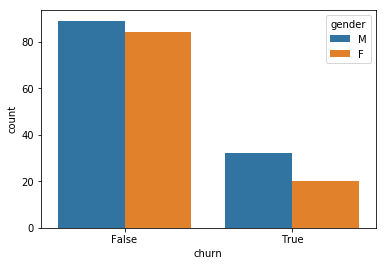

In [24]:
sns.barplot(x='churn', y='count', hue='gender', data=df_gender)

#### paid vs free users in churn pattern

In [25]:
df_level = df_churned.groupby(["churn","level"]).count().toPandas()

In [26]:
df_level

,churn,level,count
0,False,free,43333
1,False,paid,189957
2,True,paid,32476
3,True,free,12388


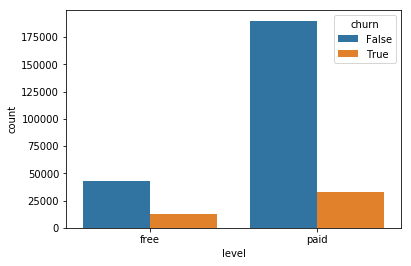

In [27]:
sns.barplot(x="level", y="count", hue='churn', data=df_level)

#### Derive time components from time variable

In [28]:
# user defined functions to extract hour, day, month from ts variable
## refernce from https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark

hr_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
day_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
mnth_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

In [29]:
# add time cols
time_cols = {'hour':hr_func, 'day':day_func, 'month':mnth_func}
for names, u_d_f in time_cols.items():
    df_churned = df_churned.withColumn(names, u_d_f(df.ts))

In [30]:
### check if above worked
#df_churned.printSchema()
#### check as pandas df
df_churn=df_churned.toPandas()

In [31]:
df_churn.head(4)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,churn,hour,day,month
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False,0,1,10
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False,0,1,10
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False,0,1,10
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False,0,1,10


In [32]:
df_churned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)



In [33]:
df_churned.select("registration").show()

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538331630000|
|1538173362000|
|1538173362000|
|1538173362000|
|1538331630000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538331630000|
|1538173362000|
|1538331630000|
|1537365219000|
|1538173362000|
|1538331630000|
+-------------+
only showing top 20 rows



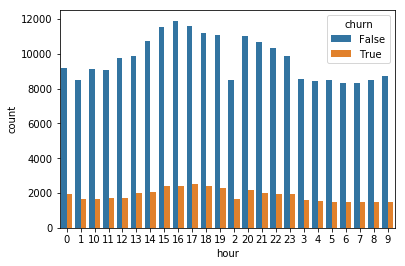

In [34]:
df_hr = df_churned.groupby(["churn","hour"]).count().sort("hour").toPandas()
sns.barplot(x="hour", y="count", hue='churn', data=df_hr)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Below are the features to be used and engineered for modelling-

1. Gender- create dummy for gender
2. Currently a paid user- create dummy for level
3. Number of songs per session
4. Song length per user session
5. Total number of sessions
6. Session duration
7. Average session per user
8. No.of artists heard
9. No.of days from registration

In [35]:
#### step 1- create dummy for gender
gender_flag = df_churned.select("userId", "gender").dropDuplicates()
gender_flag = gender_flag.replace({'M':'1', 'F':'0'}, "gender")
gender_flag = gender_flag.select("userId", gender_flag.gender.cast("int"))

/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [36]:
#gender_flag.printSchema()

In [37]:
#gender_flag.count()

In [38]:
#### step 2- a paid user or free user 
level_flag = df_churned.select("userId", "level").dropDuplicates().replace({'paid':'1', 'free':'0'}, "level")
level_flag = level_flag.select("userId", level_flag.level.cast("int"))

/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [39]:
#### step 3- songs_per_session
song_df = df_churned.filter(df_churned.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_df = song_df.groupBy('userId').agg(sF.avg('count').alias('avg_songs'))
song_df = song_df.select('userId', song_df.avg_songs.cast("float"))
song_df = song_df.na.fill(0)
song_df.show(5)

+------+---------+
|userId|avg_songs|
+------+---------+
|100010|39.285713|
|200002|     64.5|
|   125|      8.0|
|    51|    211.1|
|   124|145.67857|
+------+---------+
only showing top 5 rows



In [40]:
#### Step 4-Song length per user session
song_len=df_churned.filter(df_churned.page=='NextSong').select('userId', 'sessionId', 'length')
song_len=song_len.withColumn('hrs', (song_len.length/3600))
song_len=song_len.groupBy('userId','sessionId').sum('hrs')
song_len=song_len.groupBy('userId').agg(sF.avg('sum(hrs)').alias("avg_song_len"))
song_len=song_len.na.fill(0)
song_len = song_len.select('userId', song_len.avg_song_len.cast("float"))
song_len.show(4)

+------+------------+
|userId|avg_song_len|
+------+------------+
|100010|   2.6563847|
|200002|    4.352263|
|   125|   0.5803092|
|    51|    14.53544|
+------+------------+
only showing top 4 rows



In [41]:
#### Step 5- Total number of sessions
num_sessions = df_churned.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions = num_sessions.select('userId', num_sessions.num_sessions.cast("float"))

num_sessions.show(5)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|         7.0|
|200002|         6.0|
|   125|         1.0|
|    51|        10.0|
|   124|        29.0|
+------+------------+
only showing top 5 rows



In [42]:
#### Step 6-session duration
start_sess = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
end_sess = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')

session_dur = start_sess.join(end_sess,['userId', 'sessionId'])
session_dur = session_dur.select('userId', 'sessionId', ((session_dur.end-session_dur.start)/(1000*60*60)).alias('session_duration'))
session_dur = session_dur.select('userId', session_dur.session_duration.cast("float"))
session_dur.show(3)

+------+----------------+
|userId|session_duration|
+------+----------------+
|   101|        55.00028|
|   110|       1.3908334|
|   120|       15.855556|
+------+----------------+
only showing top 3 rows



In [43]:
# Step 7- avg session per user

avg_sess = session_dur.groupBy('userId').agg(sF.avg('session_duration').alias('mean_sess_hour'))
avg_sess = avg_sess.na.fill(0)
avg_sess = avg_sess.select('userId', avg_sess.mean_sess_hour.cast("float"))
#avg_sess.show(3)

In [44]:
#### step 8-no.of artists heard by users
count_artst = df_churned.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "count_artist")
count_artst = count_artst.select('userId', count_artst.count_artist.cast("int"))

#count_artst.show(5)

In [45]:
#### Step 9- total days from registration
recent_ts = df_churned.groupby("userId").max("ts").sort("userId")
reg_ts = df_churned.select("userId", "registration").dropDuplicates().sort("userId")
reg_days = reg_ts.join(recent_ts, reg_ts.userId == recent_ts.userId).select(reg_ts["userId"], ((recent_ts["max(ts)"]-reg_ts["registration"])/(1000*60*60*24)).alias("reg_days"))
reg_days = reg_days.select('userId', reg_days.reg_days.cast("float"))

In [46]:
#reg_days.show(3)

#### collect the features

In [47]:
feat_engineered=[gender_flag, song_df, song_len, num_sessions, avg_sess, count_artst, reg_days]

In [48]:
# prepare the final dataframe to join all the other features
level_churned = df_churned.select("userId", "churn").dropDuplicates()
level_churned = level_churned.replace({'True':'1', 'False':'0'}, "churn")
level_churned = level_churned.select("userId", level_churned.churn.cast("int"))

/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [49]:
df_final=level_churned

In [50]:
def feat_func(df1, df2):
    feat_df = df2
    df1 = df1.join(feat_df, 'userId', how='inner')
    return df1.dropDuplicates()

for feature in feat_engineered:
    print(feature)
    df_final=feat_func(df_final,feature)

DataFrame[userId: string, gender: int]
DataFrame[userId: string, avg_songs: float]
DataFrame[userId: string, avg_song_len: float]
DataFrame[userId: string, num_sessions: float]
DataFrame[userId: string, mean_sess_hour: float]
DataFrame[userId: string, count_artist: int]
DataFrame[userId: string, reg_days: float]


In [51]:
# Saving as SPARK format
#df_final.write.save('saved_user_dataset.CSV', format='csv', header=True)

In [52]:
#### check from a pandas dataframe
df_final_pds=df_final.toPandas()

In [53]:
#df_final_pds.head(10)

In [54]:
df_final_pds.to_excel('inter_data.xlsx')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [55]:
#df_final = spark.read.csv('saved_user_dataset.CSV', header = True)

In [56]:
#df_final.printSchema()

In [57]:
df_final=df_final.withColumn("userId", df_final.userId.cast(sT.IntegerType()))

In [58]:
df_final=df_final.withColumn("gender", df_final.gender.cast(sT.IntegerType()))

In [59]:
# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=df_final.columns[2:], outputCol='features')

In [60]:
# Apply the vectorization on the dataset
input_data = features_vector.transform(df_final)

In [61]:
#input_data.show(1)

In [62]:
## feature scaling
scaler = StandardScaler(inputCol="features", outputCol="ScaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(input_data)
data = scalerModel.transform(input_data)

In [63]:
#data.show(2)

In [64]:
### select input and output variables
model_data=data.select(data.churn.alias('label'), data.ScaledFeatures.alias('features'))

In [66]:
#### split train and test
train, test = model_data.randomSplit([0.80, 0.20], seed=146)

In [ ]:
#train.show(3), test.show(3)

### Logistic Vanilla Model 

In [76]:
### default model training
logstc_model =  LogisticRegression()
lr_default=logstc_model.fit(train)

In [77]:
#### testing
results = lr_default.transform(test)

In [ ]:
tp_lr = results.filter("label = 1 and prediction = 1").count()
fp_lr = results.filter("label = 0 and prediction = 1").count()
fn_lr = results.filter("label = 1 and prediction = 0").count()
precision_lr = tp_lr / (tp_lr + fp_lr) 
recall_lr = tp_lr / (tp_lr + fn_lr)
f1_lr = 2*precision_lr*recall_lr / (precision_lr+recall_lr)
print(precision_lr)
print(recall_lr)
print(f1_lr)

0.5
0.6666666666666666
0.5714285714285715


In [ ]:
lr_default.save('logistic_vanilla.model')

### Logistic with Hyper Tuning

In [71]:
#### with hyper-parameter tuning
logstc_model =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(logstc_model.elasticNetParam,[0.1, 0.5]) \
    .addGrid(logstc_model.regParam,[0.0, 0.05]) \
    .build()

crossval = CrossValidator(estimator=logstc_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [72]:
ht_Model_lr = crossval.fit(train)

In [74]:
#### testing
results_ht = ht_Model_lr.transform(test)

In [75]:
tp = results_ht.filter("label = 1 and prediction = 1").count()
fp = results_ht.filter("label = 0 and prediction = 1").count()
fn = results_ht.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

0.5
0.6666666666666666
0.5714285714285715


### Refinement of above model

In [69]:
lr_refined =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr_refined.elasticNetParam,[0.1, 0.3, 0.6, 1.0]) \
    .addGrid(lr_refined.regParam,[0.1, 0.15, 0.2]) \
    .build()

crossval_ref = CrossValidator(estimator=lr_refined,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
crossval_ref = crossval_ref.fit(train)

In [70]:
results_ref = crossval_ref.transform(test)

In [71]:
tp_ref = results_ref.filter("label = 1 and prediction = 1").count()
fp_ref = results_ref.filter("label = 0 and prediction = 1").count()
fn_ref = results_ref.filter("label = 1 and prediction = 0").count()
precision_ref = tp_ref / (tp_ref + fp_ref) 
recall_ref = tp_ref / (tp_ref + fn_ref)
f1_ref = 2*precision_ref*recall_ref / (precision_ref+recall_ref)
print(precision_ref)
print(recall_ref)
print(f1_ref)

1.0
0.16666666666666666
0.2857142857142857


### Random Forest Model

In [67]:
rf_model = RandomForestClassifier()

In [68]:
rf_default=rf_model.fit(train)

In [69]:
#### testing
results_rf = rf_default.transform(test)

In [70]:
#### scoring
tp_rf = results_rf.filter("label = 1 and prediction = 1").count()
fp_rf = results_rf.filter("label = 0 and prediction = 1").count()
fn_rf = results_rf.filter("label = 1 and prediction = 0").count()
precision_rf = tp_rf / (tp_rf + fp_rf) 
recall_rf = tp_rf / (tp_rf + fn_rf)
f1_rf = 2*precision_rf*recall_rf / (precision_rf+recall_rf)
print(precision_rf)
print(recall_rf)
print(f1_rf)

0.3
0.5
0.37499999999999994


### The Random Forest with hyperparameter tuning

In [72]:
rf_tuned = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(rf_tuned.maxDepth,[5, 10]) \
    .addGrid(rf_tuned.impurity,['entropy', 'gini']) \
    .addGrid(rf_tuned.maxBins ,[10, 5]) \
    .addGrid(rf_tuned.numTrees ,[20, 10]) \
    .addGrid(rf_tuned.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

In [73]:
crossval_rf = CrossValidator(estimator=rf_tuned,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
rf_hyper = crossval_rf.fit(train)

In [74]:
#### testing
results_rf_tuned = rf_hyper.transform(test)

In [75]:
#### scoring
tp_rf_tuned = results_rf_tuned.filter("label = 1 and prediction = 1").count()
fp_rf_tuned = results_rf_tuned.filter("label = 0 and prediction = 1").count()
fn_rf_tuned = results_rf_tuned.filter("label = 1 and prediction = 0").count()
precision_rf_tuned = tp_rf_tuned / (tp_rf_tuned + fp_rf_tuned) 
recall_rf_tuned = tp_rf_tuned / (tp_rf_tuned + fn_rf_tuned)
f1_rf_tuned = 2*precision_rf_tuned*recall_rf_tuned / (precision_rf_tuned+recall_rf_tuned)
print(precision_rf_tuned)
print(recall_rf_tuned)
print(f1_rf_tuned)

0.36363636363636365
0.6666666666666666
0.4705882352941177


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.